<a href="https://colab.research.google.com/github/zey-o/Engineering_OpenSea_LostPoets/blob/main/5_assets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This notebook first loads the origin images as scraped from the URL's provided on the the OpenSea website. It then adapts  TensorFlow's DCGAN's tutorial in order to produce 25 new poet images. The new poet images are then used in the game application. 

In order of operation: 
1. The NB first loads the images 
2. Makes generator/discriminator models 
3. Defines loss functions & optimizers 
4. Trains the model 

In [3]:
## import necessary & image libraries 
import pandas as pd
import numpy as np

import pathlib
import matplotlib.pyplot as plt

from glob import glob
import os 
import PIL
import cv2

import time
from IPython import display 

In [4]:
# import libraries for modeling 
import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load & reshape images

Load images and then resize them to the right input size that will be put into the GAN models.

In [5]:
data_dir = pathlib.Path("drive/MyDrive/LostPoets/origin_images")

In [6]:
image_count = len(list(data_dir.glob('**/*.png')))
print(image_count)

402


In [7]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = PIL.Image.open(os.path.join(folder,filename))
        img1 = img.convert('L')
        img2 = np.expand_dims(img1, axis=-1)
        if img2 is not None:
            images.append(img2)
    return images


In [8]:
train_images = load_images_from_folder(data_dir)

In [9]:
# check out the size of a single image
train_images[0].size

262144

In [10]:
train_images = np.array(train_images)
train_images.shape

(402, 512, 512, 1)

In [11]:
# resize them so that they are 28x28
train_images = tf.image.resize(train_images, [28, 28])
train_images = train_images.numpy()
train_images.shape

(402, 28, 28, 1)

In [12]:
# Normalize images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [13]:
BUFFER_SIZE = 60000
BATCH_SIZE = 28

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Make the Generator / Discriminator Models

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(10000,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [16]:
generator = make_generator_model()

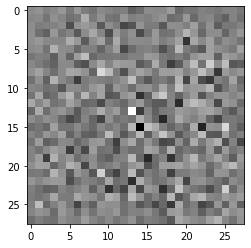

In [17]:
noise = tf.random.normal([1, 10000])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [19]:
discriminator = make_discriminator_model()

In [20]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00221204]], shape=(1, 1), dtype=float32)


## Loss Functions & Optimizers

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# this is for saving checkpoints since there will be quite a few epochs 
checkpoint_dir = 'drive/MyDrive/LostPoets/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training 

In [ ]:
num_examples_to_generate = 24
noise_dim = 10000
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
  
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
EPOCHS = 1000000

In [ ]:
def train(dataset, epochs):

  for epoch in range(epochs):
    
    for image_batch in dataset:
      train_step(image_batch)

    if (epoch +1) % 10000 ==0: 
      start = time.time()
      generate_and_save_images(generator, 
                               epoch+1, 
                               seed)
      print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # checkpoint.save(file_prefix = checkpoint_prefix)
      
      
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)
  
  images_dir = "drive/MyDrive/LostPoets/generated_images_abc"
  
  for i in range(predictions.shape[0]):
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
      plt.savefig(f'{images_dir}/{i}.png', dpi = 200)


In [ ]:
train(train_dataset, EPOCHS)

Time for epoch 10000 is 9.82117247581482 sec
Time for epoch 20000 is 19.82572293281555 sec
Time for epoch 30000 is 35.043621301651 sec
Time for epoch 40000 is 47.76874876022339 sec
Time for epoch 50000 is 59.50942873954773 sec
Time for epoch 60000 is 72.79707050323486 sec
Time for epoch 70000 is 89.09254336357117 sec
Time for epoch 80000 is 88.24789547920227 sec
Time for epoch 90000 is 98.116943359375 sec
Time for epoch 100000 is 109.62735748291016 sec
Time for epoch 110000 is 134.8569097518921 sec
Time for epoch 120000 is 147.5819594860077 sec
Time for epoch 130000 is 162.15283012390137 sec
Time for epoch 140000 is 180.89732241630554 sec
Time for epoch 150000 is 193.94235253334045 sec
Time for epoch 160000 is 202.99684834480286 sec
Time for epoch 170000 is 177.44988179206848 sec
Time for epoch 180000 is 193.65848183631897 sec
Time for epoch 190000 is 206.0128321647644 sec
Time for epoch 200000 is 208.7032253742218 sec
Time for epoch 210000 is 220.47586727142334 sec
Time for epoch 2200